# Learning Likelihood rather than posterior


    Likelihood learned fine, but the recommended sampling arviz in sbi is confusing. Switching to emcee

In [117]:
import numpy as np
import sbi
from sbi.inference import SNPE, SNLE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import emcee

from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior

# Load compressed dv and true paramters

In [3]:
compressed_dv_sims = np.load('../compression_NN/output/compressed_dv_semi_ae_v1.npy')
compressed_dv_labels = np.load('../compression_NN/output/pars_LFI.npy')

compressed_dv_fid  = np.load('../compression_NN/output/dv_compressed_fid_ae_v1.npy')

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [137]:
# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


In [157]:
def get_likelihood_estimator(N_rel, compressed_dv_sims, compressed_dv_labels):
    likelihood_list = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        p, l = compressed_dv_sims, compressed_dv_labels
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()

        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))

        inference = SNLE(density_estimator=sbi.utils.likelihood_nn(\
                        model='maf', hidden_features=50, num_transforms=4))
        likelihood_estimator = inference.append_simulations(theta, x).train()
        likelihood_list.append(likelihood_estimator)

    return likelihood_list

In [158]:
# Learn likelihood_estimator (several realizations)

NUM_SBI_REL = 3

likelihood_list = get_likelihood_estimator(NUM_SBI_REL, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_644907/1324946356.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release. Please use `from sbi.neural_nets import likelihood_nn` in the future.
  inference = SNLE(density_estimator=sbi.utils.likelihood_nn(\


 Neural network successfully converged after 371 epochs.

In [188]:
# Run MCMC with learned likelihood

lower_bound = torch.as_tensor([0.1, 0.5]) 
upper_bound = torch.as_tensor([0.45, 1.1]) 

Om_S8_prior = torch.distributions.Independent(
    torch.distributions.Uniform(lower_bound, upper_bound),
    reinterpreted_batch_ndims=1
)

gd_samples_list = []
for i in range(1): # TEST
    this_likelihood_estimator = likelihood_list[i]
    

    potential_fn, parameter_transform = likelihood_estimator_based_potential(this_likelihood_estimator,\
                                                                             prior=Om_S8_prior, x_o=compressed_dv_fid)
    posterior = MCMCPosterior(potential_fn, proposal=prior,\
                                  theta_transform=parameter_transform, warmup_steps=10)

    def log_probability(theta):
        tmp = torch.as_tensor(theta).float()
        return  posterior.log_prob(tmp).numpy() 
    
    # Initialize sampler
    ndim = 2  # Number of parameters
    nwalkers = 32  # Must be even and >= 2*ndim
    random_unit = np.random.rand(nwalkers, ndim)
    start_positions = lower_bound + (upper_bound - lower_bound) * random_unit
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

    # Run sampler
    nsteps = 10000
    sampler.run_mcmc(starting_positions, nsteps)
    this_samples = sampler.chain
    this_samples = this_samples.reshape(this_samples.shape[0]*this_samples.shape[1], this_samples.shape[2])
    this_mc_sample = MCSamples(samples=this_samples, names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(compressed_dv_labels[:, 0]), np.max(compressed_dv_labels[:, 0])], \
                "S8": [np.min(compressed_dv_labels[:, 1]), np.max(compressed_dv_labels[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45, 'ignore_rows':0.3})
    
    gd_samples_list.append(this_mc_sample)
    

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
/tmp/ipykernel_644907/1651352313.py:23: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the log-probability up to a normalizing constant. Use `.potential()` instead.
  return  posterior.log_prob(tmp).numpy()
/tmp/ipykernel_644907/1651352313.py:23: UserWarning: The log-probability is unnormalized!
  return  posterior.log_prob(tmp).numpy()
/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0


Removed 0.3 as burn in


In [198]:
gd_samples_list=[]
this_samples = this_samples.reshape(this_samples.shape[0]*this_samples.shape[1], this_samples.shape[2])
this_mc_sample = MCSamples(samples=this_samples, names=['Om', 'S8'], \
        labels=['Om', 'S8'], ranges={"Om": [np.min(compressed_dv_labels[:, 0]), np.max(compressed_dv_labels[:, 0])], \
            "S8": [np.min(compressed_dv_labels[:, 1]), np.max(compressed_dv_labels[:, 1])]},\
            label='test',\
            settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45, 'ignore_rows':0.3})

gd_samples_list.append(this_mc_sample)

Removed 0.3 as burn in


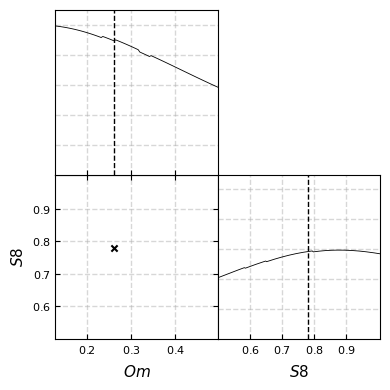

In [199]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [200]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)

In [201]:
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 1.3430330479210837
mean FoM is  1.3430330479210837
